In [48]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [49]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
np.random.seed(0)

In [51]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train,y_train = train_data['features'],train_data['labels']
X_val,y_val = val_data['features'],val_data['labels']
X_test,y_test = test_data['features'],test_data['labels']

<class 'dict'>


In [52]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0]==y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:]==(32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:]==(32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:]==(32,32,3)), "The dimensions of the images are not 32x32x3"

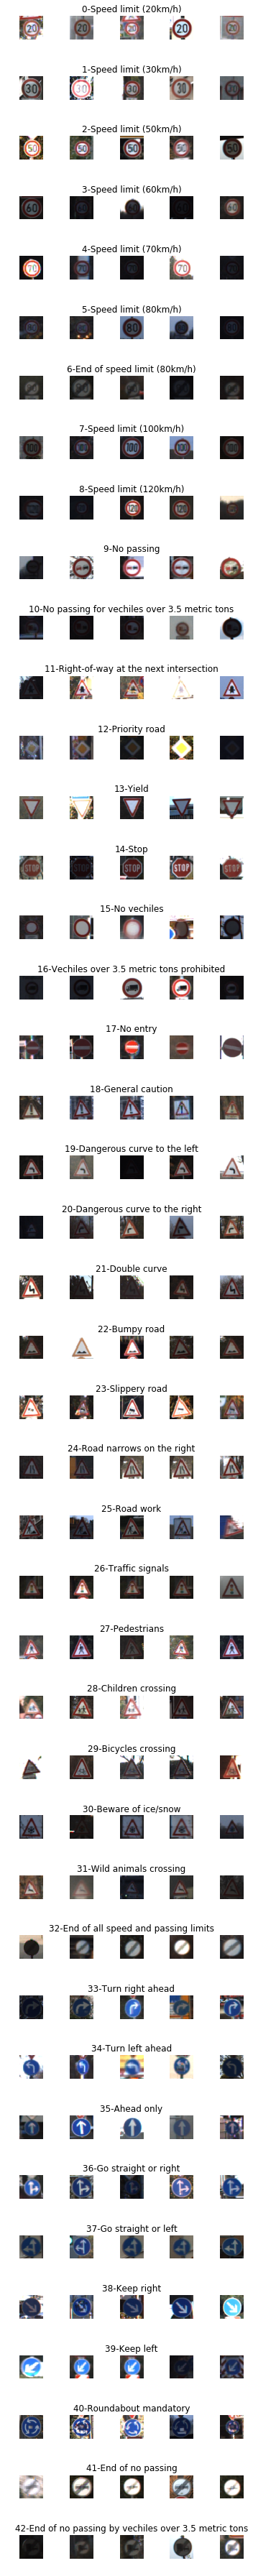

In [54]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig,axs = plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j,row in data.iterrows():
    x_selected = X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:],cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i == 2:
      axs[j][i].set_title(str(j) + '-' + row['SignName'])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


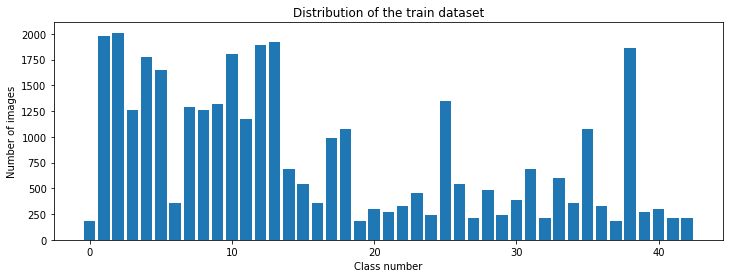

In [55]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title('Distribution of the train dataset')
plt.xlabel('Class number')
plt.ylabel('Number of images')
plt.show()

(32, 32, 3)
36


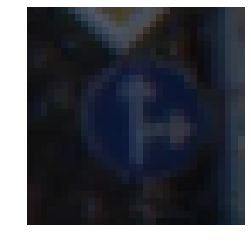

In [56]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [0]:
def grayscale(img):
  return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(-0.5, 31.5, 31.5, -0.5)

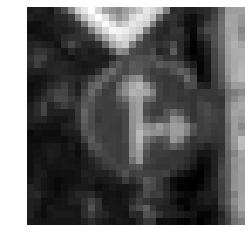

In [58]:
img = grayscale(X_train[1000])
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')

In [0]:
def equalize(img):
  return cv2.equalizeHist(img)

(32, 32)


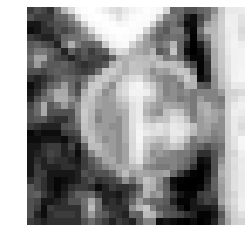

In [60]:
img = equalize(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

In [0]:
def preprocessing(img):
  return equalize(grayscale(img))/255

In [0]:
X_train = np.array(list(map(preprocessing,X_train)))
X_val = np.array(list(map(preprocessing,X_val)))
X_test = np.array(list(map(preprocessing,X_test)))

(34799, 32, 32)


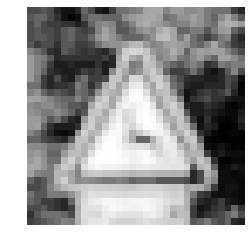

In [63]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)],cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799,32,32,1)
X_val = X_val.reshape(4410,32,32,1)
X_test = X_test.reshape(12630,32,32,1)

In [65]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)
y_test = to_categorical(y_test,43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [68]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 30)          0         
__________

In [69]:
history = model.fit(X_train,y_train,epochs=10,validation_data=[X_val,y_val],batch_size=400,verbose=1,shuffle=True)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 5s 131us/step - loss: 2.4419 - acc: 0.3422 - val_loss: 0.7806 - val_acc: 0.8091
Epoch 2/10
34799/34799 [==============================] - 3s 81us/step - loss: 0.7328 - acc: 0.7715 - val_loss: 0.3047 - val_acc: 0.9197
Epoch 3/10
34799/34799 [==============================] - 3s 80us/step - loss: 0.3990 - acc: 0.8767 - val_loss: 0.2133 - val_acc: 0.9390
Epoch 4/10
34799/34799 [==============================] - 3s 81us/step - loss: 0.2877 - acc: 0.9092 - val_loss: 0.1579 - val_acc: 0.9522
Epoch 5/10
34799/34799 [==============================] - 3s 81us/step - loss: 0.2218 - acc: 0.9320 - val_loss: 0.1095 - val_acc: 0.9667
Epoch 6/10
34799/34799 [==============================] - 3s 81us/step - loss: 0.1859 - acc: 0.9416 - val_loss: 0.1074 - val_acc: 0.9683
Epoch 7/10
34799/34799 [==============================] - 3s 81us/step - loss: 0.1605 - acc: 0.9498 - val_loss: 0.0909 - val_acc

Text(0.5, 0, 'epoch')

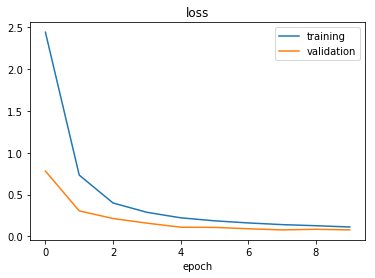

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

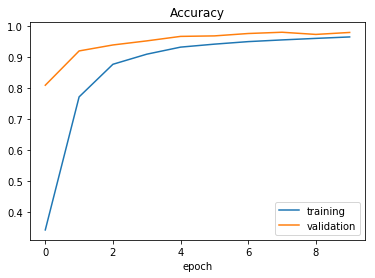

In [71]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [72]:
score = model.evaluate(X_test,y_test,verbose=0)

print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Test Score: 0.14816309116066964
Test Accuracy: 0.9566904196263493
